In [12]:
import csv

import pandas as pd
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.src.layers import GRU, Activation, LSTM
from keras import Sequential
from keras.models import Model
from keras.layers import Input, LSTM, Dense, dot, concatenate
import numpy as np
import numpy as np
import numpy as np
import numpy as np


In [13]:
# 读取数据
df = pd.read_csv('vmd_sh_data2.csv')

# 将日期列转换为日期类型
df["date"] = pd.to_datetime(df["date"])

# 将 object 类型的列转换为 float64
object_cols = df.select_dtypes(include=['object']).columns
df[object_cols] = df[object_cols].apply(lambda x: x.str.replace(',', '').astype(float))

# 根据年份划分训练集和测试集
train_data = df[df["date"].dt.year.between(2013, 2020)]
test_data = df[df["date"].dt.year.between(2021, 2023)]

# 定义特征列和目标列
features = ['BIAS', 'BOLL', 'MACD', 'VMACD', 'MA', 'RSI', 'KDJ', 'change', 'trading_volume', 'trading_value', 'IMF1',
            'IMF2', 'IMF3']
target = 'change_percent'

# 获取训练集和测试集的特征和目标变量
X_train = train_data[features]
y_train = train_data[target].values.reshape(-1, 1)  # 调整形状以适应归一化
X_test = test_data[features]
y_test = test_data[target].values.reshape(-1, 1)  # 调整形状以适应归一化

# 初始化归一化器
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# 对特征和目标变量进行归一化
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)  # 对y进行归一化
y_test_scaled = scaler_y.transform(y_test)  # 对y进行归一化

# 重塑输入数据以包含时间步维度
X_train_reshape = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
# 重塑预测数据以包含时间步维度
X_test_reshape = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

In [14]:
# 定义输入形状
T = 1  # 时间步维度
M = X_train_scaled.shape[1]  # 输入维度

# 输入层
input_sequence = Input(shape=(T, M))

units = 80
# LSTM层
lstm_out = LSTM(units, return_sequences=True)(input_sequence)

# GRU层
gru_out = GRU(units, return_sequences=True)(lstm_out)

# 注意力机制
attention = dot([gru_out, gru_out], axes=[2, 2])
attention = Dense(T, activation='sigmoid')(attention)
attention = dot([attention, gru_out], axes=[2, 1])

# 连接注意力输出和GRU输出
output = concatenate([gru_out, attention], axis=-1)

# 全连接层和回归层
output = Dense(16, activation='relu')(output)
output = Dense(1, activation='linear')(output)

# 构建模型
lstm_gru_transformer_model = Model(inputs=input_sequence, outputs=output)

# 输出网络结构
lstm_gru_transformer_model.summary()

lstm_gru_transformer_model.compile(loss='mse', optimizer='Adam')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 13)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 1, 80)                30080     ['input_2[0][0]']             
                                                                                                  
 gru_1 (GRU)                 (None, 1, 80)                38880     ['lstm_1[0][0]']              
                                                                                                  
 dot_2 (Dot)                 (None, 1, 1)                 0         ['gru_1[0][0]',               
                                                                     'gru_1[0][0]']         

In [15]:
history = lstm_gru_transformer_model.fit(X_train_reshape, y_train_scaled, batch_size=32, epochs=1000, validation_split=0.1, verbose=1)

Epoch 1/1000
55/55 [==============================] - 2s 8ms/step - loss: 0.0707 - val_loss: 0.0094
Epoch 2/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0076
Epoch 3/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0069
Epoch 4/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0068
Epoch 5/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0101 - val_loss: 0.0073
Epoch 6/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0065
Epoch 7/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0067
Epoch 8/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0065
Epoch 9/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0069
Epoch 10/1000
55/55 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0065

In [16]:
#对测试集进行预测
y_pred_scaled = lstm_gru_transformer_model.predict(X_test_reshape)

# 调整预测值形状为2D
y_pred_reshape = y_pred_scaled.reshape(-1, y_pred_scaled.shape[2])

# 反归一化预测值
y_pred = scaler_y.inverse_transform(y_pred_reshape)

23/23 [==============================] - 0s 1ms/step


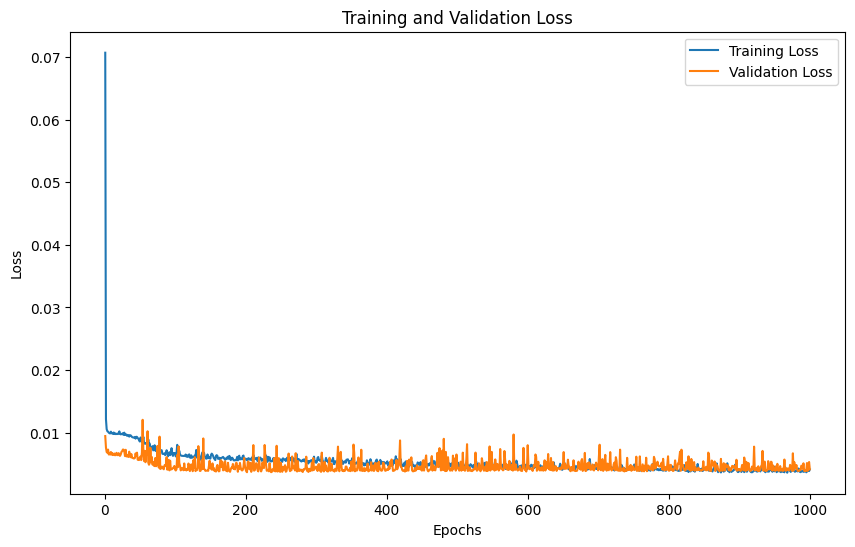

In [17]:
# 提取训练损失和验证损失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 获取训练周期数
epochs = range(1, len(train_loss) + 1)

# 绘制训练损失和验证损失的曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


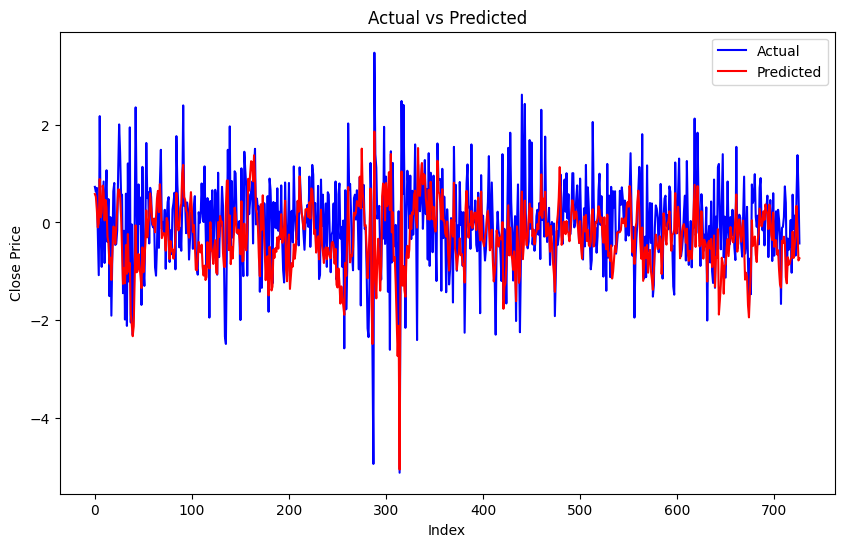

In [18]:
# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [19]:
# 检查 y_test 和 y_pred 的维度
print("y_test 维度:", y_test.ndim)
print("y_pred 维度:", y_pred.ndim)

y_test 维度: 2
y_pred 维度: 2


In [20]:
y_test
y_pred

array([[ 5.84247828e-01],
       [ 5.30400574e-01],
       [ 2.66894042e-01],
       [-9.98529196e-02],
       [-1.41739612e-02],
       [ 8.89077723e-01],
       [ 1.09124288e-01],
       [ 2.08773628e-01],
       [ 7.54979789e-01],
       [ 6.20398581e-01],
       [ 4.32024226e-02],
       [ 4.62774038e-01],
       [ 3.06856722e-01],
       [-2.94665247e-01],
       [-4.14723158e-01],
       [-8.43328655e-01],
       [-7.23169625e-01],
       [-1.17865670e+00],
       [-6.26274824e-01],
       [-8.55037272e-02],
       [-1.00960493e-01],
       [-4.38751727e-01],
       [-1.24032676e-01],
       [ 2.60695368e-01],
       [ 6.75073087e-01],
       [ 6.75174177e-01],
       [ 5.13397932e-01],
       [ 1.18464768e-01],
       [-5.67391634e-01],
       [-1.25798750e+00],
       [-9.32458639e-01],
       [-1.24648631e+00],
       [-4.63396102e-01],
       [-1.04959559e+00],
       [-2.36610219e-01],
       [-1.00955987e+00],
       [-8.30129504e-01],
       [-1.87851918e+00],
       [-2.0

In [21]:
# 将二维数组展平为一维数组，然后创建 DataFrame
df2 = pd.DataFrame({'Actual': y_test[:, 0], 'Predicted': y_pred[:, 0]})

# 计算新列，即相减结果
df2['Difference'] = df2['Actual'] - df2['Predicted']

# 将 DataFrame 保存为 CSV 文件
df2.to_csv('LSTM_GRU_Transformer_output.csv', index=False)

In [22]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mean_squared_logarithmic_error(y_true, y_pred):
    y_true_log = np.log1p(np.maximum(0, y_true))
    y_pred_log = np.log1p(np.maximum(0, y_pred))
    return np.mean((y_true_log - y_pred_log)**2)

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return np.sqrt(mean_squared_logarithmic_error(y_true, y_pred))

def normalized_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / (np.max(y_true) - np.min(y_true)))**2))


# 将损失函数结果保存到CSV文件
def save_to_csv(loss_results):
    with open('LSTM_GRU_Transformer_loss.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Loss Function", "Value"])
        for loss_name, loss_value in loss_results.items():
            writer.writerow([loss_name, loss_value])

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mbe = mean_bias_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
msle = mean_squared_logarithmic_error(y_test, y_pred)
rmsle = root_mean_squared_logarithmic_error(y_test, y_pred)
nrmse = normalized_root_mean_squared_error(y_test, y_pred)

loss_results = {
    "MAE": mae,
    "MSE": mse,
    "MBE": mbe,
    "RMSE": rmse,
    "MSLE": msle,
    "RMSLE": rmsle,
    "NRMSE": nrmse,
}
with open('LSTM_GRU_Transformer_loss.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Loss Function", "Value"])
    for loss_name, loss_value in loss_results.items():
        writer.writerow([loss_name, loss_value])
        
save_to_csv(loss_results)

print("MAE:", mae)
print("MSE:", mse)
print("MBE:", mbe)
print("RMSE:", rmse)
print("MSLE:", msle)
print("RMSLE:", rmsle)
print("NRMSE:", nrmse)

MAE: 0.6297516784465332
MSE: 0.6958826177791758
MBE: -0.26760054438518416
RMSE: 0.8341957910342007
MSLE: 0.09293822963628659
RMSLE: 0.3048577203160297
NRMSE: 0.09688685145577244


In [ ]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mean_squared_logarithmic_error(y_true, y_pred):
    y_true_log = np.log1p(np.maximum(0, y_true))
    y_pred_log = np.log1p(np.maximum(0, y_pred))
    return np.mean((y_true_log - y_pred_log)**2)

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return np.sqrt(mean_squared_logarithmic_error(y_true, y_pred))

def normalized_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / (np.max(y_true) - np.min(y_true)))**2))


# 将损失函数结果保存到CSV文件
def save_to_csv(loss_results):
    with open('LSTM_GRU_Transformer_loss.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Loss Function", "Value"])
        for loss_name, loss_value in loss_results.items():
            writer.writerow([loss_name, loss_value])

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mbe = mean_bias_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
msle = mean_squared_logarithmic_error(y_test, y_pred)
rmsle = root_mean_squared_logarithmic_error(y_test, y_pred)
nrmse = normalized_root_mean_squared_error(y_test, y_pred)

loss_results = {
    "MAE": mae,
    "MSE": mse,
    "MBE": mbe,
    "RMSE": rmse,
    "MSLE": msle,
    "RMSLE": rmsle,
    "NRMSE": nrmse,
}
with open('LSTM_GRU_Transformer_loss.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Loss Function", "Value"])
    for loss_name, loss_value in loss_results.items():
        writer.writerow([loss_name, loss_value])
        
save_to_csv(loss_results)

print("MAE:", mae)
print("MSE:", mse)
print("MBE:", mbe)
print("RMSE:", rmse)
print("MSLE:", msle)
print("RMSLE:", rmsle)
print("NRMSE:", nrmse)